# TASK
Follow directly the example from the ConditionalGaussianLikelihood.

Instead of fitting the likelihood and recovering the posterior (NLE), fit the posterior directly, with prior imposed from the data (NPE).

Compare the samples of the posterior with the analytical posterior.

In [1]:
# setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

from functools import partial
import logging
import corner
import ultranest
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from py21cmlikelihoods import ConditionalGaussian
from py21cmlikelihoods.utils import prepare_dataset

tfd = tfp.distributions
tfb = tfp.bijectors

ultranest_logger = logging.getLogger("ultranest")
ultranest_logger.addHandler(logging.NullHandler())
ultranest_logger.setLevel(logging.INFO)

2023-11-20 14:11:22.724305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# constructing the posterior
NDE = ConditionalGaussian(
    n_parameters = 5, 
    n_data = 2, 
    diagonal_covariance = False,
    n_hidden = [50] * 10,
    optimizer = tf.optimizers.Adam(1e-4), 
    kernel_initializer = "glorot_uniform",
    kernel_initializer_kwargs = {},
    # kernel_initializer = tf.keras.initializers.RandomNormal,
    # kernel_initializer_kwargs = {"mean":0.0, "stddev": 1e-3, "seed":None},
    bias_initializer = "zeros",
    bias_initializer_kwargs = {},
    last_layer_bias_initializer = None,
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=0.0, l2=1e-1),
    bias_regularizer = tf.keras.regularizers.L1L2(l1=0.0, l2=1e-3),
    regularize_last_layer = False,
)

In [3]:
# constructing the training set
mu_0 = np.random.normal(0.0, 1.0, size = 100000)
sigma_0 = np.random.uniform(0.5, 5.0, size = 100000)
params = np.stack([mu_0, sigma_0], axis = -1)
data = np.array([np.random.multivariate_normal(np.arange(1, 6)**2 * m, np.diag(np.arange(1, 6)**2 * s**2)) for m, s in params])

training_set = prepare_dataset(NDE, data_samples=params, param_samples=data, batch_size=100)

In [4]:
# training the posterior
NDE.train(
    epochs = 50,
    dataset = training_set,
    pretrain = False,
    # pretrain_epochs = 10,
    pretrain_optimizer = tf.optimizers.Adam(1e-4), 
    save = False,
    save_history = False,
    verbose = 1,
)

Epoch 1/50
1000/1000 [==============================] - 6s 3ms/step - loss: 34.4927
Epoch 2/50
1000/1000 [==============================] - 4s 3ms/step - loss: 15.3427
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - loss: 7.6931
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 4.8677
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 3.8410
Epoch 6/50
1000/1000 [==============================] - 4s 3ms/step - loss: 3.4256
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 3.2279
Epoch 8/50
1000/1000 [==============================] - 4s 3ms/step - loss: 3.1177
Epoch 9/50
1000/1000 [==============================] - 4s 3ms/step - loss: 3.0485
Epoch 10/50
1000/1000 [==============================] - 3s 3ms/step - loss: 3.0012
Epoch 11/50
1000/1000 [==============================] - 3s 3ms/step - loss: 2.9666
Epoch 12/50
1000/1000 [==============================] - 4s 3ms/step - loss: 2.9389

In [5]:
mock_measurement = np.random.multivariate_normal(np.arange(1, 6)**2, np.diag(np.arange(1, 6)**2), 10)

In [6]:
def log_gauss(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma) - 0.5 * (x - mu)**2 / sigma**2 

def analytic_log_likelihood(d, mu_0, sigma_0):
    mu = (np.arange(1, 6)**2).reshape(1, -1) * mu_0.reshape(-1, 1)
    cov = (np.arange(1, 6)**2).reshape(1, -1) * sigma_0.reshape(-1, 1)**2
    c = -2.5 * np.log(2 * np.pi) - 0.5 * np.log(np.prod(cov, axis = -1))
    l = -0.5 * np.sum((d - mu)**2 / cov, axis = -1)
    return c + l

In [14]:
def ultranest_analytic_posterior(p):
    # likelihood = np.sum(np.array([analytic_log_likelihood(mock, p[:, 0], p[:, 1]) for mock in mock_measurement]), axis = 0)
    likelihood = analytic_log_likelihood(mock_measurement[0], p[:, 0], p[:, 1])
    prior = log_gauss(0.0, p[:, 0], 1.0)
    return prior + likelihood

def transformation(p):
    x = np.zeros(p.shape, dtype = p.dtype)
    x[:, 0] = -5 + 10 * p[:, 0]
    x[:, 1] = 0.5 + 4.5 * p[:, 1]
    return x

In [15]:
sampler_analytic = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_analytic_posterior, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_analytic = sampler_analytic.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_analytic.print_results()

Z=-17.5(98.93%) | Like=-12.63..-12.61 [-12.6264..-12.6264]*| it/evals=9408/14245 eff=71.0306% N=1000  
logZ = -17.485 +- 0.102
  single instance: logZ = -17.485 +- 0.058
  bootstrapped   : logZ = -17.487 +- 0.101
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : -0.69 │ ▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▇▇▅▃▂▁▁▁▁▁▁ ▁  ▁ │2.42      1.13 +- 0.21
    sigma_0             : 0.50  │▂▄▇▇▇▇▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│5.00      1.39 +- 0.70



Recovering posterior for one mock observation $P(\mu, \sigma | d_1)$ would be very trivial. One would simply call `NDE.conditional_sample(100000, conditional = mock_measurement)`. Let's do that for the first mock measurement.

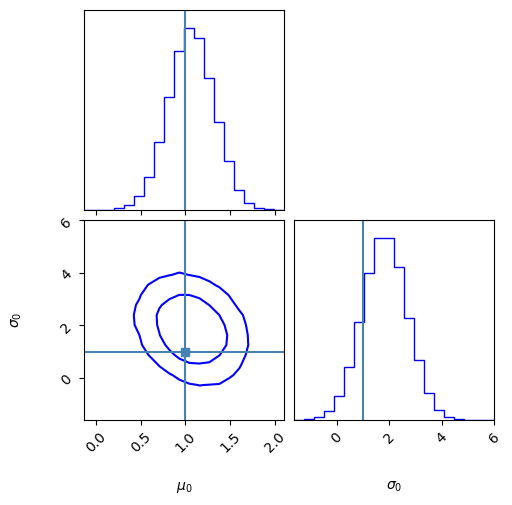

In [16]:
NDE_sample = NDE.conditional_sample(100000, conditional = mock_measurement[0])

<Figure size 500x500 with 0 Axes>

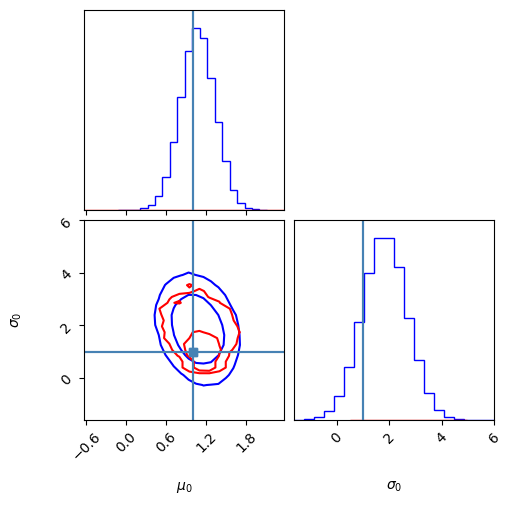

In [17]:
fig = plt.figure(figsize = (5, 5))
fig = corner.corner(
    NDE_sample.numpy(),
    truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
    color = "blue",
    labels = ["$\mu_0$", "$\sigma_0$"],
)
fig = cornerplot(result_analytic, fig, "red")

However, as we have multiple measurements, and we want to recover full posterior $P(\mu, \sigma | x_1, x_2, \ldots, x_{10})$ we can use the following trick.
$$
\begin{aligned}
P(\mu, \sigma | x_1, x_2, \ldots, x_N) &= \frac{P(x_1, x_2, \ldots, x_N | \mu, \sigma) \cdot P(\mu, \sigma)}{P(x_1, x_2, \ldots, x_N)} \\
&= \frac{1}{P(\mu, \sigma)^{N-1}}\prod_{i=1}^N \frac{P(x_i | \mu, \sigma) \cdot P(\mu, \sigma)}{P(x_i)} \\
&= P(\mu, \sigma)^{1 - N}\prod_{i=1}^N P(\mu, \sigma | x_i)
\end{aligned}
$$

Use this trick to recover the full posterior.

In [10]:
def ultranest_NDE_posterior(p):
    N = 10
    posterior_sum = np.sum(np.array([NDE.log_prob(p, mock).numpy() for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], 1.0)
    return posterior_sum + (1 - N) * prior

In [ ]:
def ultranest_analytic_posterior(p):
    likelihood = np.sum(np.array([analytic_log_likelihood(mock, p[:, 0], p[:, 1]) for mock in mock_measurement]), axis = 0)
    # likelihood = analytic_log_likelihood(mock_measurement[0], p[:, 0], p[:, 1])
    prior = log_gauss(0.0, p[:, 0], 1.0)
    return prior + likelihood

In [ ]:
sampler_analytic = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_analytic_posterior, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_analytic = sampler_analytic.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_analytic.print_results()

In [11]:
sampler_NDE = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_NDE_posterior, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_NDE = sampler_NDE.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_NDE.print_results()

Z=2.3(98.98%) | Like=8.05..8.06 [8.0526..8.0526]*| it/evals=10377/15828 eff=69.9825% N=1000 0        0 
logZ = 2.266 +- 0.093
  single instance: logZ = 2.266 +- 0.069
  bootstrapped   : logZ = 2.266 +- 0.093
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : 0.668 │ ▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▆▆▇▇▇▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁ │1.351     1.009 +- 0.080
    sigma_0             : 0.58  │ ▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▆▇▇▇▆▅▅▃▂▂▁▁▁▁▁▁▁▁ ▁ │3.00      1.80 +- 0.27



In [12]:
def cornerplot(results, fig = None, color = None):
    data = np.array(results['weighted_samples']['points'])
    weights = np.array(results['weighted_samples']['weights'])
    cumsumweights = np.cumsum(weights)

    mask = cumsumweights > 1e-4

    fig = corner.corner(
    data[mask, :],
    weights = weights[mask], 
    fig = fig, 
    color = color, 
    truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
    labels = ["$\mu_0$", "$\sigma_0$"]
)
    return fig

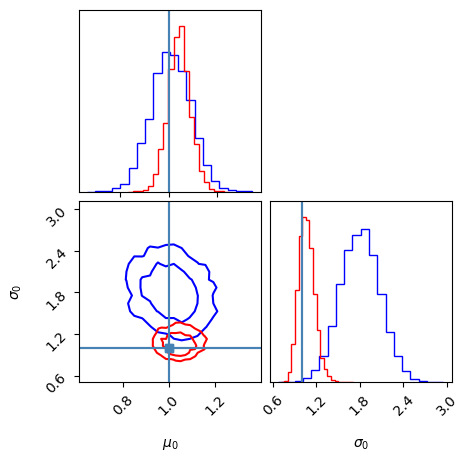

In [13]:
fig = plt.figure(figsize = (5, 5))
fig = cornerplot(result_NDE, fig, "blue")
fig = cornerplot(result_analytic, fig, "red")